In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from graphviz import *
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
def load_dfs(word_list):
    df = pd.DataFrame()
    for word in word_list:
        dfaux = pd.read_csv('2019-10-15\/' + word + '.csv'     )
        dfaux['word'] = word
        df = df.append(dfaux)
    return df.reset_index(drop=True)


def get_edges(df, combos):
    edges     = []
    for pair in combos:
        len1 = len(df[(df['word'] == pair[0]) & df['tweet.text'].str.contains('#' + pair[1])])
        len2 = len(df[(df['word'] == pair[1]) & df['tweet.text'].str.contains('#' + pair[0])])
        if len1 > len2:
            edges.append((pair[0],pair[1]))
        else:
            edges.append((pair[1],pair[0]))        
    return edges


def build_graph(word_list,edges,filename):
    g = Digraph('G', filename=filename + '.gv', engine='sfdp', format='png')
    #g = Graph(  'G', filename=filename + '.gv', engine='sfdp', format='png')

    for node in word_list:
        g.node(node)
    for edge in edges:
        g.edge(edge[0],edge[1])
    return g

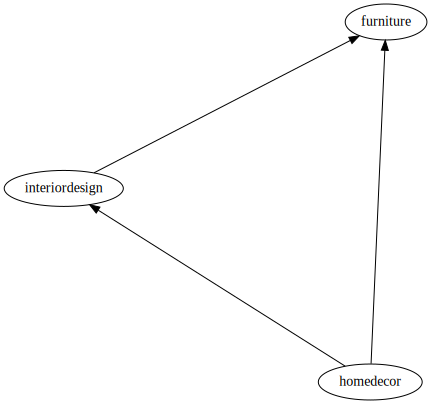

In [3]:
word_list = ['furniture', 'homedecor', 'interiordesign']
combos    = list(itertools.combinations(word_list,2))


df_tweets = load_dfs(word_list)
edges     = get_edges(df_tweets, combos)
g         = build_graph(word_list,edges,'test_0.1')

g

In [4]:
g.view()

'test_0.1.gv.png'